# <center> Overfitting et underfitting </center>

**Source :** https://www.tensorflow.org/tutorials/keras/overfit_and_underfit?hl=fr

## Importations

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
print(tf.__version__)

!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from  IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

2.11.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-0dan5520
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-0dan5520
  Resolved https://github.com/tensorflow/docs to commit 0feefb5266db5bce6ee107920b581d1e3443f511
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=178984 sha256=3fe11053e49da2c4d8f1a82856489c5c36708a5293ab69f8a910333e9eb3a326
  Stored in directory: /tmp/pip-ephem-wheel-cache-906k2h2p/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs


## Jeu de données

In [2]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816407858/2816407858 [==============================] - 142s 0us/step


In [3]:
FEATURES = 28

In [4]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

Cette classe de lecteur csv renvoie une liste de scalaires pour chaque enregistrement. La fonction suivante reconditionne cette liste de scalaires dans une paire (feature_vector, label).

In [5]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

TensorFlow est plus efficace lorsqu'il fonctionne sur de gros lots de données.

Ainsi, au lieu de reconditionner chaque ligne individuellement, créez un nouvel ensemble de `Dataset` qui prend des lots de 10 000 exemples, applique la fonction pack_row à chaque lot, puis divise les lots en enregistrements individuels :

In [6]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


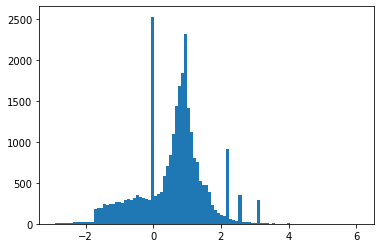

In [7]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [8]:
# 1000 pour jeu de validation et 10 000 pour le train
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [9]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [11]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [12]:
# création des batchs
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

## Améliorer l'entraînement

On peut utiliser `opimizers.schedules` pour réduire le taux d'apprentissage au fil du temps :

In [13]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

Le code ci-dessus définit un schedules.InverseTimeDecay pour réduire de manière hyperbolique le taux d'apprentissage à 1/2 du taux de base à 1000 époques, 1/3 à 2000 époques et ainsi de suite.

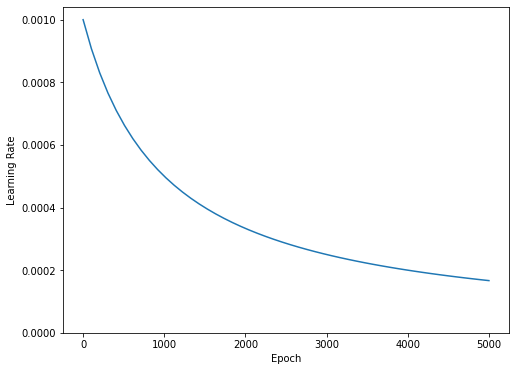

In [14]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [15]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    # early stopping = arrêt si modèle ne progresse plus
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    # générer des journaux TensorBoard pour la formation 
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [16]:
# compile et fit = identique 

def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

## Entraînement d'un petit modèle 

In [17]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [18]:
size_histories = {}

size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4770,  binary_crossentropy:0.7815,  loss:0.7815,  val_accuracy:0.5010,  val_binary_crossentropy:0.7321,  val_loss:0.7321,  
....................................................................................................
Epoch: 100, accuracy:0.5877,  binary_crossentropy:0.6326,  loss:0.6326,  val_accuracy:0.5630,  val_binary_crossentropy:0.6331,  val_loss:0.6331,  
............................................................

(0.5, 0.7)

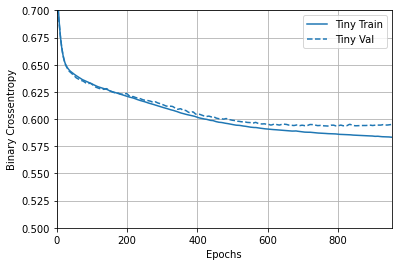

In [19]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

## Petit modèle (2 couches cachées de 16 unités)

In [21]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [22]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4826,  binary_crossentropy:0.7973,  loss:0.7973,  val_accuracy:0.4830,  val_binary_crossentropy:0.7425,  val_loss:0.7425,  
....................................................................................................
Epoch: 100, accuracy:0.6327,  binary_crossentropy:0.6077,  loss:0.6077,  

## Modèle moyen (3 couches cachées de 64 unités)

In [23]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [24]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                1856      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4947,  binary_crossentropy:0.7056,  loss:0.7056,  val_accuracy:0.4660,  val_binary_crossentropy:0.6838,  val_loss:0.6838,  
....................................

## Grand modèle (4 couches cachées de 512 unités)

In [25]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [26]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               14848     
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dense_13 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5197,  binary_crossentropy

## Affichage dans Tensorboard

In [28]:
#docs_infra: no_execute

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 42286), started 0:00:06 ago. (Use '!kill 42286' to kill it.)

<IPython.core.display.Javascript object>

In [29]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

## Stratégies pour éviter le surajustement

In [37]:
# copies des journaux d'entraînement du modèle
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmpzdvp8sz1/tensorboard_logs/regularizers/Tiny')

In [38]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### Ajouter une régularisation du poids

Vous connaissez peut-être le principe du rasoir d'Occam : étant donné deux explications pour quelque chose, l'explication la plus susceptible d'être correcte est la « plus simple », celle qui fait le moins d'hypothèses. Cela s'applique également aux modèles appris par les réseaux de neurones : compte tenu de certaines données d'entraînement et d'une architecture de réseau, il existe plusieurs ensembles de valeurs de poids (plusieurs modèles) qui pourraient expliquer les données, et les modèles plus simples sont moins susceptibles de sur-ajuster que les modèles complexes.

Un "modèle simple" dans ce contexte est un modèle où la distribution des valeurs de paramètres a moins d'entropie (ou un modèle avec moins de paramètres au total, comme nous l'avons vu dans la section ci-dessus). Ainsi, un moyen courant d'atténuer le surajustement consiste à imposer des contraintes sur la complexité d'un réseau en forçant ses poids à ne prendre que de petites valeurs, ce qui rend la distribution des valeurs de poids plus "régulière". C'est ce qu'on appelle la "régularisation des poids", et cela se fait en ajoutant à la fonction de perte du réseau un coût associé au fait d'avoir des poids importants. Ce coût se présente sous deux formes :

- Régularisation L1 , où le surcoût est proportionnel à la valeur absolue des coefficients des poids (c'est-à-dire à ce qu'on appelle la « norme L1 » des poids).

- Régularisation L2 , où le surcoût est proportionnel au carré de la valeur des coefficients des poids (c'est-à-dire à ce qu'on appelle le carré de la "norme L2" des poids). La régularisation L2 est également appelée décroissance de poids dans le contexte des réseaux de neurones. Ne laissez pas le nom différent vous confondre : la perte de poids est mathématiquement identique à la régularisation L2.

La régularisation L1 pousse les poids vers exactement zéro, encourageant un modèle clairsemé. La régularisation L2 pénalisera les paramètres de poids sans les rendre clairsemés puisque la pénalité passe à zéro pour les petits poids - une des raisons pour lesquelles L2 est plus courant.

Dans tf.keras , la régularisation du poids est ajoutée en passant des instances de régularisateur de poids aux couches en tant qu'arguments de mot-clé. Ajoutons maintenant la régularisation du poids L2.

In [39]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 512)               14848     
                                                                 
 dense_25 (Dense)            (None, 512)               262656    
                                                                 
 dense_26 (Dense)            (None, 512)               262656    
                                                                 
 dense_27 (Dense)            (None, 512)               262656    
                                                                 
 dense_28 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5129,  binary_crossentropy

(0.5, 0.7)

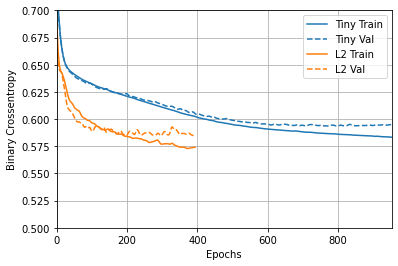

In [40]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [41]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

## Dropout

In [42]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 512)               14848     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_30 (Dense)            (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_31 (Dense)            (None, 512)               262656    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_32 (Dense)            (None, 512)              

(0.5, 0.7)

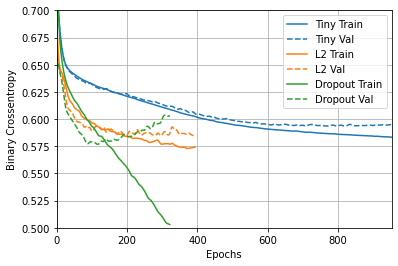

In [43]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

  ## Combiné L2 + Dropout

In [44]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 512)               14848     
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_35 (Dense)            (None, 512)               262656    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_36 (Dense)            (None, 512)               262656    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_37 (Dense)            (None, 512)              

(0.5, 0.7)

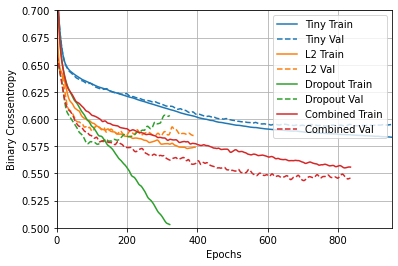

In [45]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

## Afficher dans Tensorboard

In [46]:
%tensorboard --logdir {logdir}/regularizers

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-03-02 14:18:24.374300: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-02 14:18:24.374476: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-02 14:18:24.374488: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023-03-02 14:18:26.196425: E tensorfl

In [47]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")

## Conclusion 

Pour récapituler : voici les moyens les plus courants d'éviter le surajustement dans les réseaux de neurones :

- Obtenez plus de données d'entraînement.
- Réduire la capacité du réseau.
- Ajouter la régularisation du poids.
- Ajouter un décrochage.

Deux approches importantes non couvertes dans ce guide sont :
- augmentation de données
- normalisation par lots

Rappelez-vous que chaque méthode peut aider seule, mais souvent les combiner peut être encore plus efficace.